# Explorarion 13. DCGAN 을 이용한 패션 디자인

## 1. 데이터 준비

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Fashion MNIST 데이터는 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가진다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이번 프로젝트에서는 Fashion MNIST 데이터 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눈다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요하다.  

Fashion MNIST 데이터의 경우는 흑백 이미지이므로 채널 값 1을 shape 마직에 추가하겠다.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

__데이터 확인__

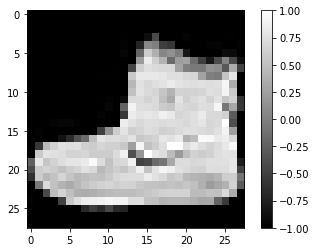

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

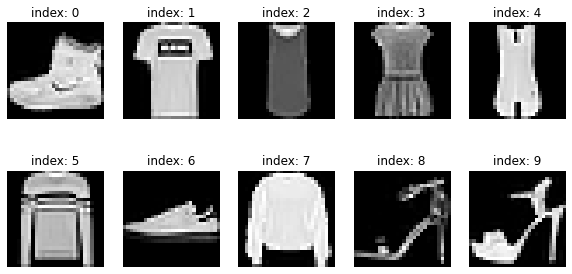

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

----


`BUFFER_SIZE` 는 전체 데이터를 섞기 위해 60000 으로 설정한다.  
`BATCH_SIZE` 는 모델이 한 번에 학습할 데이터의 양이다.   
시간 단축과 메모리 활용을 효율적으로 하기 위해 적절한 사이즈로 잘라서 학습을 진행하는 방식을 미니배치 학습이라고 한다.

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

`tf.data.Dataset` 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.   

`train_x` 라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나눈다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

모델의 구현은 Keras Sequential API를 활용하였다.   

이후 소개하는 코드는 [Tensorflow 2.0 Tutorial의 DCGAN 구현](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)을 기반으로 상세한 설명을 추가하였다.

----
## 2. 생성자 (Generator) 구현

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

`make_generator_model` 이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 한다.   

함수 내부에서는 먼저 `tf.keras.Sequential()` 로 모델을 시작한 후 레이어를 차곡차곡 쌓는다.  

- 생성자의 입력 벡터
  - 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받음  
  

- `Dense` 레이어
  - 처음 입력된(batch_size,100) 벡터는  7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됨



- `Reshape` 레이어
  - 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시킴

  


- `Conv2DTranspose` 레이어
  - 가장 중요한 레이어
  - Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
  - 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나감
  - 여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일함
  

- `BatchNormalization` 레이어
  - 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화


- 중간층의 활성화 함수는 모두 `LeackyReLU` 를 사용  
 
  
  

- 마지막 층 활성화 함수로 `tanh` 사용
  - -1~1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

그럼 모델이 만들어졌으니, shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보자.  
아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것이다.

`tf.random.normal` 을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

In [13]:
noise = tf.random.normal([1, 100])

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 `call` 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다.  


지금은 학습하는 중이 아니니 training=False를 설정해주어야한다.

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

`matplotlib` 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (28, 28) shape의 이미지로 시각화 해보겠다.

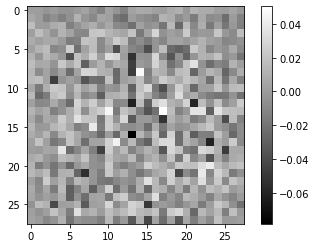

In [15]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

----
## 3. 판별자 (Discriminator) 구현

판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야한다.  
그렇다면 입력은 (28, 28, 1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것이다. 

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.  


- 첫 번째 `Conv2D` 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됨

- 마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환한다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 

- 1차원 벡터로 변환한 후에는 마지막 `Dense` Layer를 거쳐 단 하나의 값을 출력한다.

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00179202]], dtype=float32)>

----
## 4. 손실함수 (loss function)

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.  
판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, __이진 교차 엔트로피(binary cross entropy)__를 사용한다.  

Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같다.
- __생성자__ : 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)` 값이 `1`에 가까워지는 것
- __판별자__ : Real Image 판별값, 즉 `D(real_image)`는 1에, Fake Image 판별값, 즉 `D(fake_image)`는 `0`에 가까워지는 것


우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다.  

- `from_logits` 
  - `tf.keras.losses`의 `BinaryCrossEntropy` 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
  - 따라서 `from_logits`를 `True`로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있음

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 `fake_output`와 `real_output`, 두 가지를 활용한다.
- `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
- `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

`tf.ones_like()`와 `tf.zeros_like()` 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용한다. 이 함수를 사용하여 `fake_output`과 `real_output`을 각각 1 또는 0에 비교 할 수 있다.

- `generator_loss`
  - `fake_output`가 1에 가까워지기를 바라므로, `tf.ones_like`와의 교차 엔트로피값을 계산
  - cross_entropy(`tf.ones_like(fake_output)`, `fake_output`) 값은 `fake_output`이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐
  

- `discriminator_loss`
  - `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산
  - `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교
  - __최종 discriminator_loss 값은 이 둘을 더한 값__

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.  

- real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
- fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같다.
- (1) `tf.math.greater_equal(real_output, tf.constant(0.5)` : real_output의 각 원소가 0.5 이상인지 True, False로 판별
- (2) `tf.cast( (1), tf.float32)` : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
- (3) `tf.reduce_mean( (2))` : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산

### 최적화 함수(optimizer)

생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.  
 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정한다.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

샘플은 한 번에 16장을 생성한다.  

생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야한다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어둔다.

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

----
## 5. 훈련과정 설계

`@tf.function` 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다.

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) __입력데이터__: Real Image 역할을 할 images 한 세트를 입력으로 받음


- (2) __생성자 입력 노이즈__ : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함


- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기


- (4) __generated_images 생성__ : generator가 noise를 입력받은 후 generated_images 생성


- (5) __discriminator 판별__ : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력


- (6) __loss 계산__ : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산


- (7) __accuracy 계산__ : fake_output, real_output으로 discriminator의 정확도 계산  


- (8) __gradient 계산__ : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산


- (9) __모델 학습__ : 계산된 gradient를 optimizer에 입력해 가중치 갱신  


- (10) __리턴값__ : 이번 스텝에 계산된 loss와 accuracy를 리턴  

이러한 일련의 과정을 통해 한 번의 `train_step` 이 끝나게 된다.

이렇게 한 단계씩 학습할 `train_step`과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들자.  

아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [45]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

`train_step()` 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어보자.  

예를 들어 생성자의 loss의 history는 `history['gen_loss']`로 접근할 수 있는 list로 관리할 예정이다.

In [46]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음으로 정기적으로 모델을 저장하기 위한 checkpoint를 만든다.   

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.  
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이다.

In [47]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

----
## 6. 모델 학습

지금까지 한 단계를 학습하는 `train_step`, 샘플 이미지를 생성하고 저장하기 위한 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 그리고 모델까지 저장하기 위한 `checkpoint`까지 모두 준비가 되었으니 이것들을 한 곳에 합쳐서 최종 `train` 함수를 만들고 모델을 학습시킨다.

In [48]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [49]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

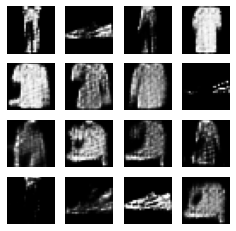

Time for training : 1499 sec


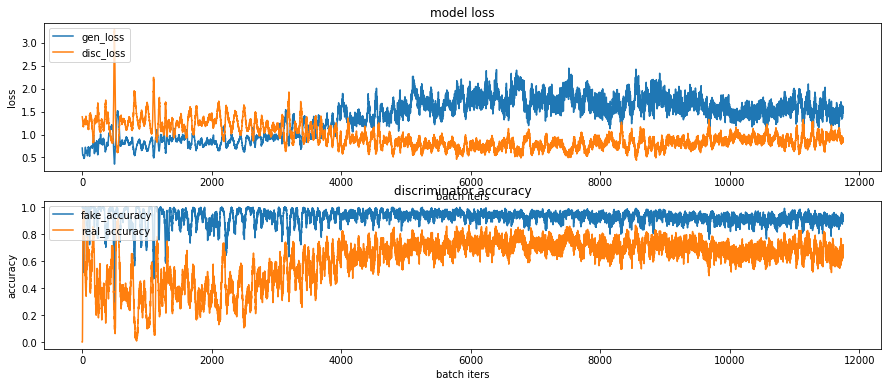

CPU times: user 7min 27s, sys: 48.4 s, total: 8min 16s
Wall time: 25min


In [50]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있음
# 진행 과정을 수시로 확인

생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻이다.

### 학습과정 시각화
학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보자.  

GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식으로 만들 수 있다.


In [51]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1304369 Sep  2 04:07 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![fashion_mnist_dcgan](https://user-images.githubusercontent.com/84179578/131780710-82a123d4-eaf4-4587-a642-061e1c1d95f7.gif)

fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있다.